<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Hermitian%20Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing dependencies 

### For google colab

In [1]:
! git clone https://github.com/nahumsa/DM-Reconstruction

Cloning into 'DM-Reconstruction'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 994.62 KiB | 7.65 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 4.9MB 3.3MB/s 
  Created wheel for qutip: filename=qutip-4.5.1-cp36-cp36m-linux_x86_64.whl size=14333892 sha256=bcd85dc2a57a51c2284eda30c8f28d2367a241a4f9d76ce0493982b6edc7ea6e
  Stored in directory: /root/.cache/pip/wheels/8e/50/3d/29fb07fa1c0fbca787cff4376446b88a58bf628e324cee6c95
Successfully built qutip


In [1]:
% cd DM-Reconstruction/

/content/DM-Reconstruction


## Importing

In [0]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip
from tqdm.notebook import tqdm

## Creating the dataset

In [5]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

print(f"Shape of the Training: \n X: {X_train.shape}")

Shape of the Training: 
 X: (5000, 15)


## Generating the density matrices from 16 parameters

In [0]:
def matrix_gen(t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15):
  mat = np.zeros((4,4), dtype=np.complex128)
  mat[0,0] = t0
  mat[1,1] = t1
  mat[2,2] = t2
  mat[3,3] = t3
  mat[1,0] = t4 + 1j*t5
  mat[2,0] = t10 + 1j*t11
  mat[2,1] = t6 + 1j*t7
  mat[3,0] = t14 + 1j*t15
  mat[3,1] = t12 + 1j*t13
  mat[3,2] = t8 + 1j*t9
  return mat

def create_hermitian(params: list):
  matrix = matrix_gen(*params)
  matrix_dag = np.conj(matrix.T)
  return matrix_dag@matrix/np.trace(matrix_dag@matrix)

def hermitian_tensorflow(params: tf.Tensor):  
  tf_matrix = []  
  for parameters in params:#.numpy():
    tf_matrix.append(create_hermitian(parameters))
  return tf.Variable(tf_matrix, dtype=tf.dtypes.complex64)

## Models

In [0]:
from Utils.QMetrics import create_2qubit_density_mat, trace_dist

def trace_loss(y_true,y_pred):
  y_true = tf.cast(y_true, tf.dtypes.complex64, name='Casting_true')
  y_pred = tf.cast(y_pred, tf.dtypes.complex64, name='Casting_pred')
  d_y_true = create_2qubit_density_mat(y_true)  
  d_y_pred = hermitian_tensorflow(y_pred)   
  return tf.reduce_mean(trace_dist(d_y_pred,d_y_true))

In [0]:
from Models.TVAE import TraceVAE2

class TraceHermitian(TraceVAE2):
  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,  
               final_dim,           
               **kwargs):    

    super(TraceHermitian, self).__init__(original_dim,
                                   intermediate_dim,
                                   latent_dim,
                                   final_dim)
    
  def training_step(self, x, r_loss, beta):
    """Training step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data.
    VAE(tf.keras.Model): Variational Autoencoder model. 
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.
    Return:
    Loss(float): Loss value of the training step.
    """
    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      # Compute loss.      
      loss = trace_loss(x, reconstructed)
      kl = sum(self.losses)
      loss = r_loss * loss + beta*kl  
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))        
    return loss

In [0]:
ZDIM = 2
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32

vae = TraceHermitian(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM,
               final_dim=input_dim+1)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

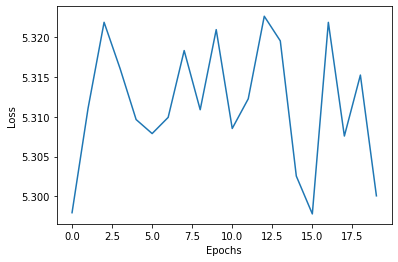

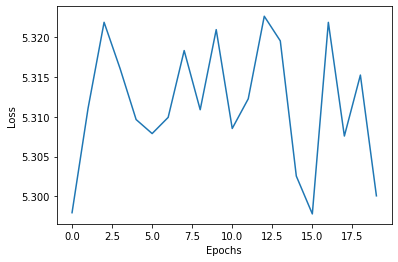

In [22]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = vae.training(dataset, epochs, r_loss, beta, Plotter=plotter)